# Cleaning & Plotting!

## GOALS

1. Identify a search term or hashtag having to do with an urban (or related) issue, problem, or application (e.g., #muralarts, #patco, #wisconsinrecount, etc.)
2. Adapt the code provided for the class examples to do the following:
<ul>
    <li>a. Extract the most recent (at most) 10,000 tweets that contain that search term/hashtag</li>
    <li>b. Clean the tweets (i.e., remove stop words, numbers, suffixes, etc.)</li>
    <li>c. Create a word cloud of the terms in the tweets</li>
    <li>d. Map the tweets</li>
<ul>

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

import time
import requests
from datetime import datetime
import calendar

from matplotlib import pyplot as plt
import seaborn as sns

import hvplot.pandas
import holoviews as hv

In [132]:
tweets = pd.read_csv(r'.\data\geo_results.csv')
geos = pd.read_csv(r'.\data\tweet_places2.csv')

In [6]:
geos.head()

tweet_places     full_name
0           NaN           NaN
1    Austin, TX    Austin, TX
2  Brooklyn, NY  Brooklyn, NY
3           NaN           NaN
4           NaN           NaN

In [7]:
tweets.head()

created_at  geo                   id  \
0  2021-12-13 04:05:36+00:00  NaN  1470243481507360768   
1  2021-12-13 04:05:29+00:00  NaN  1470243453217001474   
2  2021-12-13 04:05:11+00:00  NaN  1470243378566557698   
3  2021-12-13 04:04:35+00:00  NaN  1470243224685932547   
4  2021-12-13 04:04:17+00:00  NaN  1470243150253879297   

                                                text withheld  
0  RT @PBBabscbn: You have the power to vote for ...      NaN  
1  RT @thetirekinge: @lekurokami Omg! Poor baby. ...      NaN  
2  RT @iamjavid111: Best Female Contestant In BB ...      NaN  
3  RT @Article14live: #Hindu extremists attacked ...      NaN  
4  RT @real_khabri_1: It is really sad to see mak...      NaN

### Get rid of URLS

In [10]:
print(tweets["text"][1])

RT @thetirekinge: @lekurokami Omg! Poor baby. Imagine having the best sleep of your life only to be evicted by the landlord cause you outgr…


In [133]:
def remove_url(txt):
    """
    Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    import re
    return " ".join(re.sub("https://t.co/[A-Za-z\\d]+|&amp", "", txt).split())

In [134]:
### Other Approach
tweets["tweets_no_urls"] = [remove_url(tweet) for tweet in tweets["text"]]


In [135]:
tweets["tweets_no_urls"][:5]

0    RT @PBBabscbn: You have the power to vote for ...
1    RT @thetirekinge: @lekurokami Omg! Poor baby. ...
2    RT @iamjavid111: Best Female Contestant In BB ...
3    RT @Article14live: #Hindu extremists attacked ...
4    RT @real_khabri_1: It is really sad to see mak...
Name: tweets_no_urls, dtype: object

### Removing user accounts b/c somehow we still got retweets, this will also remove users at'd in tweets

In [115]:
import regex as re 

#/(@\S+)/

In [142]:
tweets["tweets_no_ats"] = [re.sub(r"(@\S+)", "", tweet) for tweet in tweets["tweets_no_urls"]]

In [143]:
tweets["tweets_no_ats"][:10]

0    RT  You have the power to vote for Alexa! To V...
1    RT   Omg! Poor baby. Imagine having the best s...
2    RT  Best Female Contestant In BB House RJ KAJA...
3    RT  #Hindu extremists attacked his prayer serv...
4    RT  It is really sad to see makers bringing #U...
5    RT  It is really sad to see makers bringing #U...
6    RT  How much will you white wash Tejasswi's im...
7    Grabe ang ganda ng conversation nila Samantha,...
8    RT  It is really sad to see makers bringing #U...
9    Idhula PaPri fans yarayum eliminate pandradhuk...
Name: tweets_no_ats, dtype: object

### Extract a list of lower-cased words in a tweet

- `.lower()` makes all words lower cased
- `.split()` splits a string into the individual words

In [144]:
### Other Approach

#tweets["formatted_text"]= tweets["tweets_no_urls"].str.lower() # <--if want to keep accounts use this
tweets["formatted_text"]= tweets["tweets_no_ats"].str.lower()

### Remove stop words and punctuation

Common words that do not carry much significance and are often ignored in text analysis.

In [145]:
# import stop words

import nltk
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
stop_words = list(set(nltk.corpus.stopwords.words('english')))
stop_words[:-10]

['won',
 'that',
 "mightn't",
 'some',
 'the',
 "wasn't",
 'y',
 'doing',
 "that'll",
 's',
 'yours',
 'be',
 'or',
 "should've",
 'wouldn',
 'those',
 'other',
 'haven',
 'while',
 'we',
 'shouldn',
 'wasn',
 'what',
 'because',
 'who',
 'with',
 "didn't",
 'your',
 'after',
 'here',
 'by',
 'should',
 'his',
 'too',
 'through',
 'from',
 'yourself',
 'during',
 'i',
 've',
 'needn',
 "you're",
 'same',
 't',
 're',
 'into',
 'up',
 "shan't",
 'weren',
 'themselves',
 'himself',
 'does',
 "haven't",
 'on',
 'herself',
 'been',
 'am',
 'they',
 "you've",
 'both',
 'has',
 'down',
 'mightn',
 "you'll",
 'me',
 'ma',
 'shan',
 'such',
 'these',
 'll',
 'under',
 'o',
 "needn't",
 'off',
 'but',
 'where',
 'd',
 'about',
 'hasn',
 'why',
 'few',
 'between',
 'no',
 "weren't",
 'will',
 'very',
 'then',
 'in',
 'yourselves',
 'ain',
 'once',
 'him',
 'can',
 'mustn',
 "shouldn't",
 "won't",
 'all',
 'against',
 "you'd",
 'whom',
 'were',
 'now',
 'at',
 'theirs',
 'do',
 'when',
 'only',
 

In [147]:
## gotta get rid of "rt" too.
rt = ["rt"]
rt

['rt']

### Get the list of common punctuation

In [148]:
import string

In [149]:
punctuation = list(string.punctuation)
punctuation[:5]

['!', '"', '#', '$', '%']

## Remove stop words from our tweets

In [150]:
ignored = stop_words + punctuation + rt

In [151]:
### Other Approach

tweets["formatted_text_nsw"] = tweets["formatted_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (ignored)]))

In [152]:
tweets["formatted_text_nsw"][:5]

0    power vote alexa! vote via kumu: go kumu campa...
1    omg! poor baby. imagine best sleep life evicte...
2    best female contestant bb house rj kajal evict...
3    #hindu extremists attacked prayer service, #ka...
4    really sad see makers bringing #umarriaz profe...
Name: formatted_text_nsw, dtype: object

In [153]:
#using this fn that Nick provided, b/c strings like 'wow!' wouldn't drop punct
def remove_punctuation(sentence):
    """
    Remove punctuation from the input sentence.
    """
    translator = str.maketrans('', '', string.punctuation)
    return sentence.translate(translator)

In [154]:
#removing punctuation
tweets["formatted_text_nsw2"] = [remove_punctuation(word)for word in tweets["formatted_text_nsw"]]

In [155]:
tweets["formatted_text_nsw2"][:5]

0    power vote alexa vote via kumu go kumu campaig...
1    omg poor baby imagine best sleep life evicted ...
2    best female contestant bb house rj kajal evict...
3    hindu extremists attacked prayer service karna...
4    really sad see makers bringing umarriaz profes...
Name: formatted_text_nsw2, dtype: object

In [157]:
 tweets_nsw_2= tweets["formatted_text_nsw2"]

In [158]:
 tweets_nsw_2

0        power vote alexa vote via kumu go kumu campaig...
1        omg poor baby imagine best sleep life evicted ...
2        best female contestant bb house rj kajal evict...
3        hindu extremists attacked prayer service karna...
4        really sad see makers bringing umarriaz profes...
                               ...                        
49623    thats reason want evicted deserving khud ka ko...
49624    lockdown corruption covid vaccination corrupti...
49625    inis din ako kay idol kasi iniyakan ko evictio...
49626    slump ratings even want cant evict umarriaz wi...
49627                                           60 evicted
Name: formatted_text_nsw2, Length: 49628, dtype: object

### Counting word frequencies

We'll define a helper function to calculate word frequencies from our lists of words.

In [161]:
from pandas import Series, merge

In [167]:
tweets.head()

created_at  geo                   id  \
0  2021-12-13 04:05:36+00:00  NaN  1470243481507360768   
1  2021-12-13 04:05:29+00:00  NaN  1470243453217001474   
2  2021-12-13 04:05:11+00:00  NaN  1470243378566557698   
3  2021-12-13 04:04:35+00:00  NaN  1470243224685932547   
4  2021-12-13 04:04:17+00:00  NaN  1470243150253879297   

                                                text withheld  \
0  RT @PBBabscbn: You have the power to vote for ...      NaN   
1  RT @thetirekinge: @lekurokami Omg! Poor baby. ...      NaN   
2  RT @iamjavid111: Best Female Contestant In BB ...      NaN   
3  RT @Article14live: #Hindu extremists attacked ...      NaN   
4  RT @real_khabri_1: It is really sad to see mak...      NaN   

                                      tweets_no_urls  \
0  RT @PBBabscbn: You have the power to vote for ...   
1  RT @thetirekinge: @lekurokami Omg! Poor baby. ...   
2  RT @iamjavid111: Best Female Contestant In BB ...   
3  RT @Article14live: #Hindu extremists attacked ...   
4  RT @real_khabri_1: It is really sad to see mak...   

                                       tweets_no_ats  \
0  RT  You have the power to vote for Alexa! To V...   
1  RT   Omg! Poor baby. Imagine having the best s...   
2  RT  Best Female Contestant In BB House RJ KAJA...   
3  RT  #Hindu extremists attacked his prayer serv...   
4  RT  It is really sad to see makers bringing #U...   

                                      formatted_text  \
0  rt  you have the power to vote for alexa! to v...   
1  rt   omg! poor baby. imagine having the best s...   
2  rt  best female contestant in bb house rj kaja...   
3  rt  #hindu extremists attacked his prayer serv...   
4  rt  it is really sad to see makers bringing #u...   

                                  formatted_text_nsw  \
0  power vote alexa! vote via kumu: go kumu campa...   
1  omg! poor baby. imagine best sleep life evicte...   
2  best female contestant bb house rj kajal evict...   
3  #hindu extremists attacked prayer service, #ka...   
4  really sad see makers bringing #umarriaz profe...   

                                 formatted_text_nsw2  \
0  power vote alexa vote via kumu go kumu campaig...   
1  omg poor baby imagine best sleep life evicted ...   
2  best female contestant bb house rj kajal evict...   
3  hindu extremists attacked prayer service karna...   
4  really sad see makers bringing umarriaz profes...   

                                     formatted_text3  
0  [power, vote, alexa, vote, via, kumu, go, kumu...  
1  [omg, poor, baby, imagine, best, sleep, life, ...  
2  [best, female, contestant, bb, house, rj, kaja...  
3  [hindu, extremists, attacked, prayer, service,...  
4  [really, sad, see, makers, bringing, umarriaz,...

In [166]:
tweets["formatted_text3"] = tweets["formatted_text_nsw2"].str.split()

#### instead used this fn 

In [156]:
def count_word_frequencies(words_in_tweet, top=15):
    """
    Given a list of all words for every tweet, count
    word frequencies across all tweets.
    
    By default, this returns the top 15 words, but you 
    can specify a different value for `top`.
    """
    import itertools, collections

    # List of all words across tweets
    all_words = list(itertools.chain(*words_in_tweet))

    # Create counter
    counter = collections.Counter(all_words)
    
    return pd.DataFrame(counter.most_common(top),
                        columns=['words', 'count'])

In [172]:
counts_nsw = count_word_frequencies(tweets["formatted_text3"])
counts_nsw.head()

words  count
0   evicted  16281
1      vote  14527
2     evict  12330
3  eviction   9711
4      kumu   7818

### Plotting with our keyterms

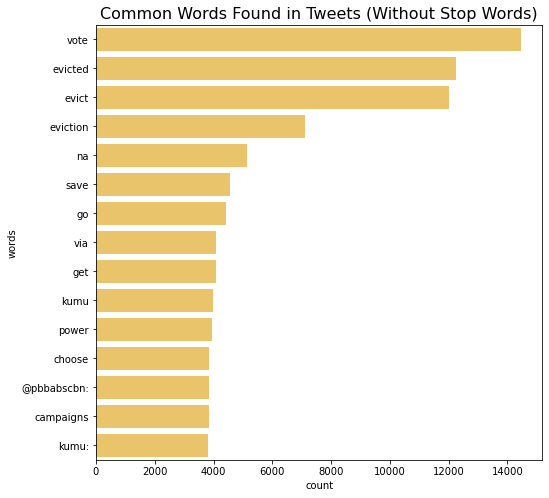

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y="words",
    x="count",
    data=counts_nsw.sort_values(by="count", ascending=False),
    ax=ax,
    color="#e9c46aff",
    saturation=1.0,
)

ax.set_title("Common Words Found in Tweets (Without Stop Words)", fontsize=16);

### Plotting withOUT our keyterms

In [30]:
search_terms = ['evictions', "evicted", "evict", "eviction"]
tweets_final = [[w for w in word if w not in search_terms]
                 for word in tweets_nsw]


tweets["formatted_text3"]

In [31]:
# frequency counts
counts_final = count_word_frequencies(tweets_final)

In [176]:
search_terms = ['evictions', "evicted", "evict", "eviction", "via"]
tweets["tweets_final"] = [[w for w in word if w not in search_terms]
                 for word in tweets["formatted_text3"]]




In [177]:
# frequency counts
counts_final = count_word_frequencies(tweets["tweets_final"])

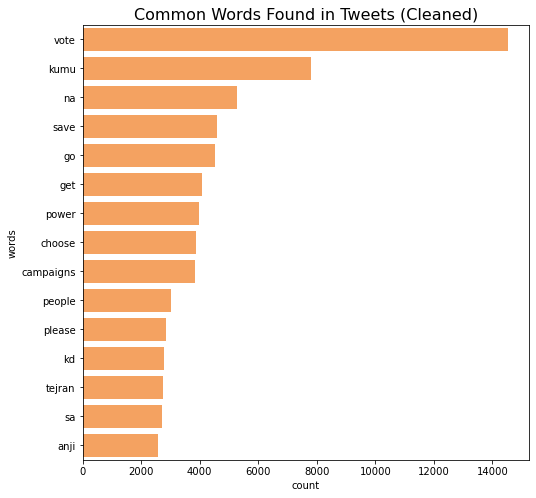

In [178]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y="words",
    x="count",
    data=counts_final.sort_values(by="count", ascending=False),
    ax=ax,
    color="#f4a261ff",
    saturation=1.0,
)

ax.set_title("Common Words Found in Tweets (Cleaned)", fontsize=16)
plt.savefig('commonwords.png')


## WordCloud

In [181]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [211]:
    X = (tweets["tweets_final"]
         .apply(Series)
         .stack()
         .reset_index(level=1, drop=True)
         .to_frame('word'))

In [215]:
Xlist = X["word"]

In [199]:
Xlist = X["word"].tolist()

In [216]:
# Python program to convert a list
# to string using join() function
    
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))
        

In [217]:
# Driver code    
s = Xlist
text = listToString(s)

In [218]:
text

'power vote alexa vote kumu go kumu campaigns choose vote save vote hou… omg poor baby imagine best sleep life landlord cause outgr… best female contestant bb house rj kajal evicted👏👏hugs stuffs footage candidates finalist biggboss5telugu hindu extremists attacked prayer service karnataka pastor somu avaradhi jailed 10 days landlord evic… really sad see makers bringing umarriaz profession time again least something house… really sad see makers bringing umarriaz profession time again least something house… much white wash tejasswis image entire week passed cheap comments shamitashetty behin… grabe ang ganda ng conversation nila samantha madam inutz alyssa jordan kila anji kd huhu mas lalo kaming panatag dahil kayo kasama nila sa bnk sana next week walang kahit imposible😭 bbs anji bbs kd really sad see makers bringing umarriaz profession time again least something house… idhula papri fans yarayum eliminate pandradhukaga vote poda mattangalamlast week target akshara bigbosstamil5 would co

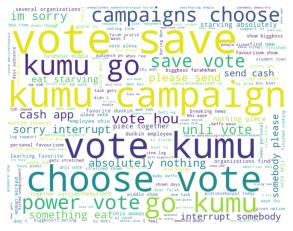

In [224]:


wordcloud = WordCloud(width = 900, height = 700,
                background_color ='white', min_font_size = 10).generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file("./peace_and_love.png")
#plt.savefig('wordcloud.png')

## Mapping Tweets

In [33]:
from geopy.geocoders import Nominatim

In [38]:
unique_places = geos["full_name"].unique()

In [81]:
uplaces = unique_places.tolist()

In [82]:
uplaces.remove('Central Region, Singapore')
uplaces.remove("Perambur Purasavakam, India")
uplaces.remove("Anekal Bangaluru, India")
uplaces.remove("Rae Bareily, India")

In [73]:
uplaces

[nan,
 'Austin, TX',
 'Brooklyn, NY',
 'Pennsylvania, USA',
 'Guwahati, India',
 'Glasgow, Scotland',
 'Galway, Ireland',
 'Pinellas Park, FL',
 'North Region, Singapore',
 'Calumet City, IL',
 'Silver Spring, MD',
 'Phoenix, AZ',
 'Colorado, USA',
 'Sparks, NV',
 'Nevada, USA',
 'Hayathnagar, India',
 'Chirala, India',
 'Tacloban City, Eastern Visayas',
 'Dunwoody, GA',
 'East Point, GA',
 'Zanesville, OH',
 'Mandaue City, Central Visayas',
 'Davao City, Davao Region',
 'Dasmarinas, Calabarzon',
 'Pasay City, National Capital Region',
 'Olongapo City, Central Luzon',
 'Salfords, South East',
 'Israel',
 'Cagayan De Oro City, Northern Mindanao',
 'Golborne, England',
 'Rietberg, Deutschland',
 'Rajendra Nagar, India',
 'Worcester, England',
 'Ajman, United Arab Emirates',
 'Buffalo, NY',
 'Hyderabad, India',
 'New York, USA',
 'Faversham, England',
 'Arkansas, USA',
 'Dallas, TX',
 'Republic of the Philippines',
 'Mandaluyong City, National Capital Region',
 'Tanza, Calabarzon',
 'Pitt

In [ ]:
needplaces = ["Central Region, Singapore"]

In [79]:
geolocator = Nominatim(user_agent="577a81d8-9516-4fb7-b388-eea95f6d4cbe")
location = geolocator.geocode("Rae Bareily, India")
print((location.latitude, location.longitude))

AttributeError: 'NoneType' object has no attribute 'latitude'

In [83]:
locations = []
lats = []
lngs = []
for i in uplaces:
    print(i)
    locations.append(i)
    geolocator = Nominatim(user_agent="577a81d8-9516-4fb7-b388-eea95f6d4cbe")
    location = geolocator.geocode(i)
    lat = location.latitude
    lng = location.longitude
    lats.append(lat)
    lngs.append(lng)
print("done")

nan
Austin, TX
Brooklyn, NY
Pennsylvania, USA
Guwahati, India
Glasgow, Scotland
Galway, Ireland
Pinellas Park, FL
North Region, Singapore
Calumet City, IL
Silver Spring, MD
Phoenix, AZ
Colorado, USA
Sparks, NV
Nevada, USA
Hayathnagar, India
Chirala, India
Tacloban City, Eastern Visayas
Dunwoody, GA
East Point, GA
Zanesville, OH
Mandaue City, Central Visayas
Davao City, Davao Region
Dasmarinas, Calabarzon
Pasay City, National Capital Region
Olongapo City, Central Luzon
Salfords, South East
Israel
Cagayan De Oro City, Northern Mindanao
Golborne, England
Rietberg, Deutschland
Rajendra Nagar, India
Worcester, England
Ajman, United Arab Emirates
Buffalo, NY
Hyderabad, India
New York, USA
Faversham, England
Arkansas, USA
Dallas, TX
Republic of the Philippines
Mandaluyong City, National Capital Region
Tanza, Calabarzon
Pittsburgh, PA
Catalina Foothills, AZ
Andhra Pradesh, India
Alabama, USA
Manhattan, NY
West Midlands, England
Hillsboro, OR
Queens, NY
Warsaw, Poland
Vellakoil, India
Victoria,

In [84]:
geos_geocoded = pd.DataFrame(list(zip(locations,lats, lngs)),columns =["locations","lat", "lng"])

In [85]:
geos_geocoded.head()

locations        lat        lng
0                NaN  46.314475  11.048029
1         Austin, TX  30.271129 -97.743700
2       Brooklyn, NY  40.652601 -73.949721
3  Pennsylvania, USA  40.969989 -77.727883
4    Guwahati, India  26.180598  91.753943

In [86]:
geos_geocoded.to_csv('geos_geocoded.csv', index=False)

In [87]:
geoscoded = pd.read_csv(r'.\data\geos_geocoded.csv')

In [88]:
geoscoded.head()

locations        lat        lng
0                NaN  46.314475  11.048029
1         Austin, TX  30.271129 -97.743700
2       Brooklyn, NY  40.652601 -73.949721
3  Pennsylvania, USA  40.969989 -77.727883
4    Guwahati, India  26.180598  91.753943

In [89]:
geoscoded["geometry"] = gpd.points_from_xy(geoscoded['lng'], geoscoded['lat'])

In [90]:
geoscoded_gdf = gpd.GeoDataFrame(data= geoscoded, geometry="geometry", crs="EPSG:4326")

In [91]:
geoscoded_gdf.head()

locations        lat        lng                    geometry
0                NaN  46.314475  11.048029   POINT (11.04803 46.31448)
1         Austin, TX  30.271129 -97.743700  POINT (-97.74370 30.27113)
2       Brooklyn, NY  40.652601 -73.949721  POINT (-73.94972 40.65260)
3  Pennsylvania, USA  40.969989 -77.727883  POINT (-77.72788 40.96999)
4    Guwahati, India  26.180598  91.753943   POINT (91.75394 26.18060)

In [97]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

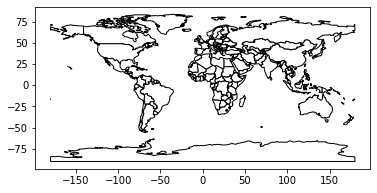

In [98]:
base = world.plot(color='white', edgecolor='black')

In [102]:
geoscoded_gdf.plot(ax = base, marker='*', color='green', markersize=5);

<Figure size 432x288 with 0 Axes>

In [104]:
geogdf = geoscoded_gdf.to_crs(world.crs)
 "#f4a261ff", "#e76f51ff"

In [112]:
import contextily as cx

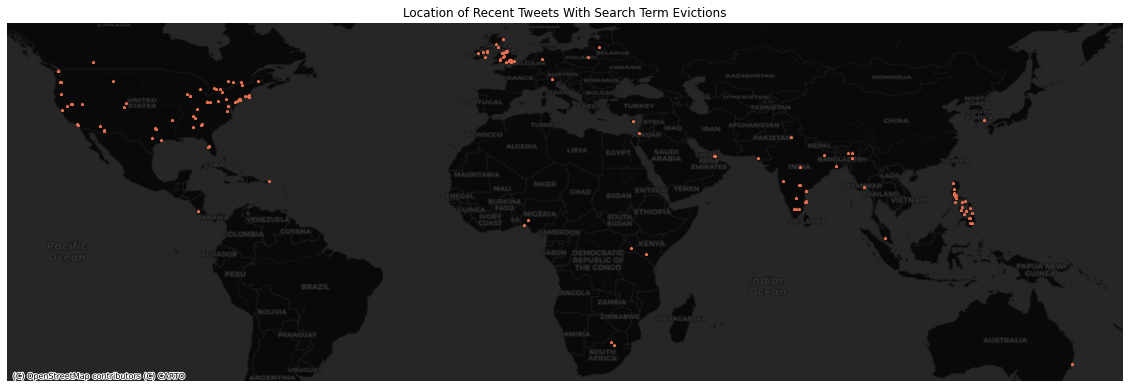

In [125]:
fig, ax = plt.subplots(figsize=(20, 10))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.

#ax.set_aspect('equal')

#world.plot(ax=ax, color='white', edgecolor='black')

geoscoded_gdf.plot(ax = ax, marker='*', color="#e76f51ff", markersize=7)

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, crs=geoscoded_gdf.crs)
ax.set_axis_off()
ax.set(title="Location of Recent Tweets With Search Term Evictions")

plt.savefig('tweetsWorld.png')